## AdaBoost

It essentially follows the philosophy of "learning from your mistakes."

To implement this from scratch, we need two components:
- A Decision Stump: A simple one-level tree that splits data based on one feature and one threshold.
- The Boosting Logic: A loop that adjusts sample weights and calculates each stump's "Amount of Say" ($\alpha$).

#### The Math Behind the Logic

Before the code, here are the two critical formulas used in the implementation:
- Error ($\epsilon$): The sum of weights of misclassified samples.
- Amount of Say ($\alpha$): How much we trust this stump:

$$\alpha = \frac{1}{2} \ln \left( \frac{1 - \epsilon}{\epsilon} \right)$$

- Weight Update: We increase the weight for wrong predictions and decrease for correct ones:

$$w_{new} = w_{old} \cdot e^{\pm \alpha}$$

In [7]:
import numpy as np

class DecisionStump:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.alpha = None
        self.polarity = 1 # Used to flip the decision (e.g., < vs >)

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions

class AdaBoost:
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators
        self.stumps = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize weights to 1/N
        weights = np.full(n_samples, (1 / n_samples))

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            min_error = float('inf')

            # Greedy search for the best split (Best Stump)
            for feat_i in range(n_features):
                X_column = X[:, feat_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # Check both polarities
                    for polarity in [1, -1]:
                        predictions = np.ones(n_samples)
                        if polarity == 1:
                            predictions[X_column < threshold] = -1
                        else:
                            predictions[X_column > threshold] = -1

                        # Error is the sum of weights of misclassified samples
                        error = sum(weights[y != predictions])

                        if error < min_error:
                            min_error = error
                            stump.polarity = polarity
                            stump.threshold = threshold
                            stump.feature_idx = feat_i

            # Calculate Amount of Say (Alpha)
            # Add a small epsilon to avoid division by zero
            eps = 1e-10
            stump.alpha = 0.5 * np.log((1.0 - min_error + eps) / (min_error + eps))

            # Update weights: w = w * exp(-alpha * y * y_pred)
            # This automatically increases weight for wrong predictions
            predictions = stump.predict(X)
            weights *= np.exp(-stump.alpha * y * predictions)
            
            # Normalize weights so they sum to 1
            weights /= np.sum(weights)

            self.stumps.append(stump)

    def predict(self, X):
        # Final prediction: sign(sum(alpha * stump_prediction))
        stump_preds = [stump.alpha * stump.predict(X) for stump in self.stumps]
        y_pred = np.sum(stump_preds, axis=0)
        return np.sign(y_pred)

# --- Quick Test ---
if __name__ == "__main__":
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    # Load data and convert labels to -1 and 1
    data = datasets.load_breast_cancer()
    X, y = data.data, data.target
    y = np.where(y == 0, -1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = AdaBoost(n_estimators=10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = np.sum(y_train == clf.predict(X_train)) / len(y_train)
    print(f"Training Accuracy: {accuracy:.4f}")
    
    test_acc = np.sum(y_test == y_pred) / len(y_test)
    print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9802
Testing Accuracy: 0.9474


##### Key Takeaways

- Greedy Search: The fit method iterates through every feature and every unique value to find the split that minimizes the weighted error.
- Polarity: A stump doesn't just check "if X > threshold"; it also checks "if X < threshold" (the polarity) to see which way labels the data better.
- The Weights: Note how weights *= np.exp(-stump.alpha * y * predictions) works. If $y$ and predictions have the same sign (correct), the exponent is negative, making the weight smaller. If they differ (wrong), the exponent is positive, making the weight larger.
- Ensemble Power: No single stump is very accurate, but by summing their weighted votes, the final predict function becomes quite robust.

|Feature	| AdaBoost (Weighting)|	Gradient Boosting (Residuals)|
|----|----|----|
| Main Idea|	Fixes mistakes by increasing the "importance" of hard-to-classify samples.	| Fixes mistakes by training the next model to predict the remaining error. |
| Weak Learner	| Usually Decision Stumps (depth=1).	| Usually Regression Trees (depth=3 to 8).|
|How it updates	| Adjusts sample weights based on error.	| Performs Gradient Descent on a loss function.|
| Final Prediction |	A weighted vote of all learners. |	The initial mean + sum of all predicted residuals.|


#### 2. How Gradient Boosting Works (The "Residual" Logic)

In Gradient Boosting, we don't change the weights of the rows in the dataset. Instead, we change the Target Variable ($y$) for each new tree.

- 1. Start with a Base Prediction: Usually the average of all target values (e.g., if predicting house prices, start with the mean price).
- 2. Calculate Residuals: Find the difference between the actual value and the current prediction: $Residual = Actual - Predicted$.
- 3. Train a Tree on Residuals: The next tree is NOT trained to predict $y$; it is trained to predict the Residuals.
- 4. Update the Prediction: Add a scaled version (using a Learning Rate) of the new tree's output to the previous prediction.
- 5. Repeat: Keep calculating the new residuals and training new trees to fix them until the error is minimized.

### The Mathematical View

In AdaBoost, we minimize an exponential loss function.6 In Gradient Boosting, we can minimize any differentiable loss function (like Mean Squared Error or Log Loss).

If our loss function is $L(y, \hat{y})$, Gradient Boosting essentially calculates the Gradient (slope) of that loss:

$$\text{Residual} \approx -\frac{\partial L(y, \hat{y})}{\partial \hat{y}}$$

Instead of taking a step in the direction of the gradient with a single model (like standard Gradient Descent), we add a new model that points in the direction of the gradient.

#### Which one is better?

- AdaBoost is often faster and easier to set up, but it is very sensitive to outliers because it will try desperately to "weight up" an outlier it can't classify, potentially ruining the model.

- Gradient Boosting is much more flexible and generally more accurate. It forms the basis for modern "state-of-the-art" libraries like XGBoost, LightGBM, and CatBoost.


## Three most important visualizations are:
- 1. Staged Decision Boundaries: Seeing how the boundary gets more complex as you add more learners.
- 2. Staged Error Rate: A plot of training vs. test error to check for convergence and overfitting.
- 3. Alpha vs. Weighted Error: Visualizing the relationship between a weak learner's error and its "Amount of Say" ($\alpha$).

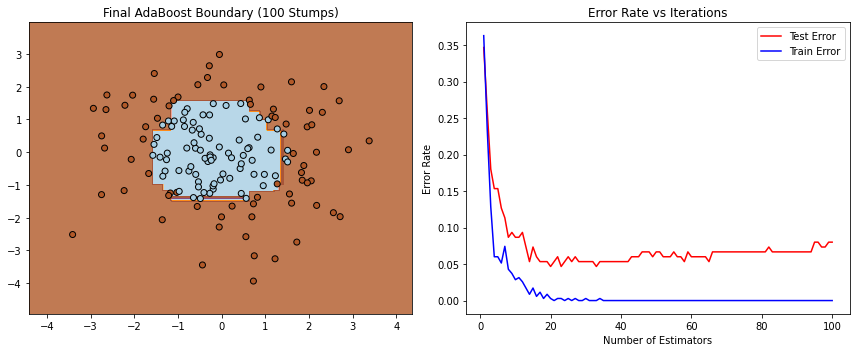

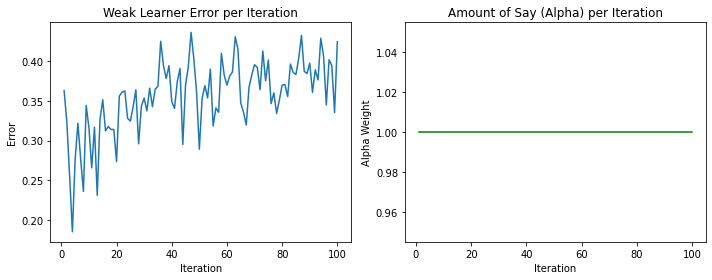

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Create a complex synthetic dataset
X, y = make_gaussian_quantiles(cov=2., n_samples=500, n_features=2,
                                 n_classes=2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Fit AdaBoost
n_estimators = 100
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         n_estimators=n_estimators, random_state=42)
bdt.fit(X_train, y_train)

# --- VISUALIZATION 1: Decision Boundary ---

def plot_decision_boundary(clf, X, y, ax, title):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(bdt, X_test, y_test, ax1, f"Final AdaBoost Boundary ({n_estimators} Stumps)")

# --- VISUALIZATION 2: Staged Error Rate ---

test_errors = []
for y_pred in bdt.staged_predict(X_test):
    test_errors.append(1.0 - accuracy_score(y_test, y_pred))

train_errors = []
for y_pred in bdt.staged_predict(X_train):
    train_errors.append(1.0 - accuracy_score(y_train, y_pred))

ax2.plot(range(1, n_estimators + 1), test_errors, label='Test Error', color='red')
ax2.plot(range(1, n_estimators + 1), train_errors, label='Train Error', color='blue')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('Error Rate')
ax2.set_title('Error Rate vs Iterations')
ax2.legend()
plt.tight_layout()
plt.show()

# --- VISUALIZATION 3: Estimator Weights (Alpha) vs Error ---

estimator_errors = bdt.estimator_errors_
estimator_weights = bdt.estimator_weights_

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_estimators + 1), estimator_errors)
plt.title("Weak Learner Error per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")

plt.subplot(1, 2, 2)
plt.plot(range(1, n_estimators + 1), estimator_weights, color='green')
plt.title("Amount of Say (Alpha) per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha Weight")
plt.tight_layout()
plt.show()

#### Why these graphs matter:
- 1. Decision Boundary: Notice how individual stumps are just straight vertical or horizontal lines. The final AdaBoost boundary is "jagged"—it is a combination of many straight lines that together approximate a circle or complex shape.

- 2. Error Rate (Convergence): AdaBoost is famous for not overfitting easily. Even after the training error hits zero, the test error often continues to drop. This is due to the "margin" increasing as you add more learners.

- 3. Alpha vs. Error: In the third plot, you will see an inverse relationship. If a weak learner has a high error (close to 0.5), its Alpha (Amount of Say) will drop toward 0, meaning the ensemble ignores it.